# Stock-creation compounded option-pricing error (per company)
This notebook computes, for each company CSV in `./Companies/`, an error metric using **volatility compounded from stock creation**.

Implementation detail: we emulate `days_bef_start_point = len(file)` (i.e., start at creation) by clamping the start index to 1.

**Metric shown**: average absolute percentage error across sequential 1-year periods.

In [12]:
# Imports
import os, glob, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [13]:
# Metric function: average absolute % error when sigma is estimated from stock-creation-to-start returns
def avg_abs_pct_change_stock_creation(filename, r=0.035, T=1, trading_days=252):
    df = pd.read_csv(os.path.join('./Companies', filename))
    if 'Close' not in df.columns or len(df) < trading_days + 2:
        return np.nan

    close = df['Close'].astype(float).to_numpy()
    # Log returns
    rets = np.full(len(close), np.nan)
    rets[1:] = np.log(close[1:] / close[:-1])

    n = len(close)
    days_bef_start_point = n  # forces start at creation via clamp

    pct_errors = []
    for i in range(trading_days, n, trading_days):
        start = n - i - days_bef_start_point
        end = n - i
        if start < 1:
            start = 1
        if end <= start + 3:
            continue

        sigma = np.nanstd(rets[start:end], ddof=1) * math.sqrt(trading_days)
        if not np.isfinite(sigma) or sigma <= 0:
            continue

        S0 = float(close[-i])
        K = S0
        d1 = (((r + 0.5 * sigma**2) * T) + math.log(S0 / K)) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
        option_price = S0 * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)

        expiry_idx = -i + (trading_days - 1)
        if abs(expiry_idx) > len(close):
            continue
        S_exp = float(close[expiry_idx])

        diff = S_exp - S0 - option_price
        pct_errors.append((diff / S0) * 100.0)

    if len(pct_errors) == 0:
        return np.nan
    return float(np.mean(np.abs(pct_errors)))


In [14]:
# Compute metric for each company CSV
files = sorted(glob.glob('./Companies/*.csv'))
files = [os.path.basename(f) for f in files]

rows = []
for f in files:
    company = f.split('_')[0]
    metric = avg_abs_pct_change_stock_creation(f)
    rows.append({'company': company, 'file': f, 'avg_abs_pct_change': metric})

results = (pd.DataFrame(rows)
           .sort_values('avg_abs_pct_change', ascending=False, na_position='last')
           .reset_index(drop=True))
results


,company,file,avg_abs_pct_change
0,plug,plug_us_d.csv,224.678857
1,enph,enph_us_d.csv,116.331073
2,tesla,tesla_us_d.csv,83.867901
3,amazon,amazon_us_d.csv,70.309487
4,fslr,fslr_us_d.csv,63.853782
5,apple,apple_us_d.csv,42.992664
6,eog,eog_us_d.csv,32.093815
7,wmb,wmb_us_d.csv,30.367900
8,walmart,walmart_us_d.csv,28.897421
9,microsoft,microsoft_us_d.csv,27.500548


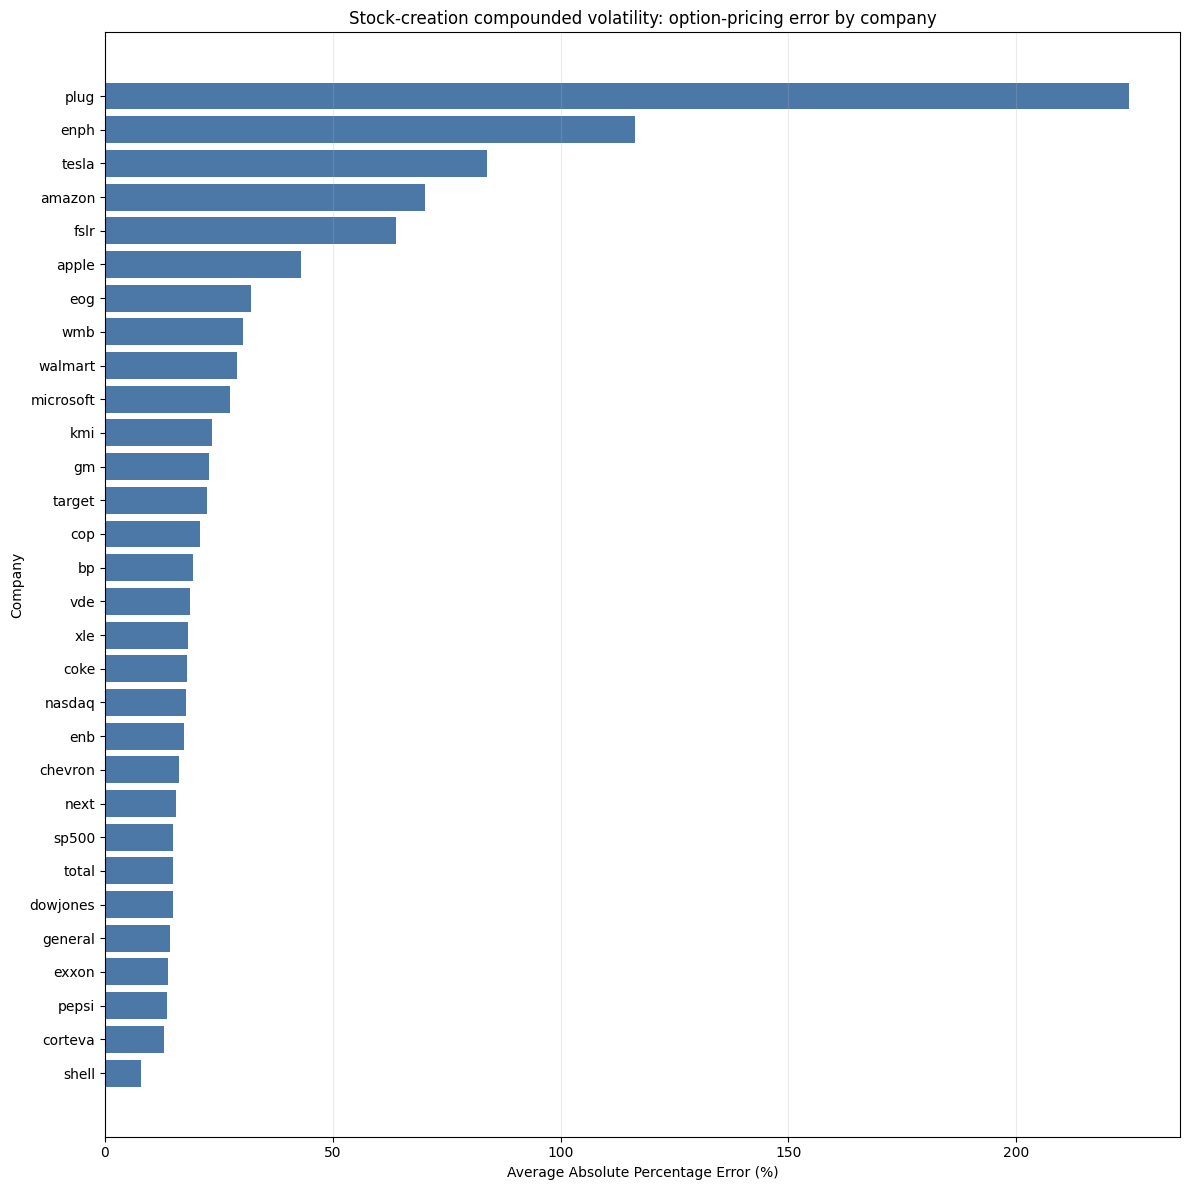

In [15]:
# Bar chart visualization (sorted)
plot_df = results.dropna(subset=['avg_abs_pct_change']).copy()
plot_df = plot_df.sort_values('avg_abs_pct_change', ascending=True)

plt.figure(figsize=(12, max(6, 0.4 * len(plot_df))))
plt.barh(plot_df['company'], plot_df['avg_abs_pct_change'], color='#4C78A8')
plt.xlabel('Average Absolute Percentage Error (%)')
plt.ylabel('Company')
plt.title('Stock-creation compounded volatility: option-pricing error by company')
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
# Save the table as a CSV artifact
os.makedirs('artifacts', exist_ok=True)
out_csv = 'artifacts/avg_abs_pct_change_stock_creation_per_company.csv'
results.to_csv(out_csv, index=False)
out_csv
